# Iceberg Tree Figure

Create sample molecule tree 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
import json
from collections import defaultdict

from ms_pred import common
from ms_pred.common import plot_utils
import ms_pred.magma.fragmentation as fe
from ms_pred.common.plot_utils import *

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import pydot

set_style()


%load_ext autoreload
%autoreload 2

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Prelim
dataset_name = "nist20"
dataset_name = "canopus_train_public"
data_folder = Path(f"../data/spec_datasets/{dataset_name}/")
magma_folder = data_folder / "magma_outputs/magma_tree"
labels = data_folder / "labels.tsv"
labels_df = pd.read_csv(labels, sep="\t")
name_to_smi = dict(labels_df[["spec", "smiles"]].values)
results_folder = Path("../results/figs_iceberg/")
results_folder.mkdir(exist_ok=True)

CCMSLIB00000085486


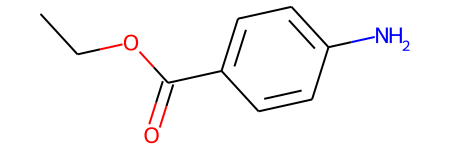

In [3]:
# Select for a reasonably small and tractable molecule
mask = [(len(i) > 10 and len(i) < 20) 
        for i in labels_df['smiles']]
labels_df_sub = labels_df[mask].reset_index()

# Methocarbamol is ind 8
ind = 14 #8 #4 is best contender # 14 is good
entry = labels_df_sub.loc[ind]
smi = entry.smiles
spec_res_folder = results_folder / f"example_{entry['spec']}"
spec_res_folder.mkdir(exist_ok=True)
print(entry['spec'])
Chem.MolFromSmiles(smi)

In [4]:

spec_name = entry['spec']
print(spec_name)
magma_input = magma_folder / f"{spec_name}.json"  
magma_tree = json.load(open(magma_input, "r"))
#magma_tree.keys()
engine = fe.FragmentEngine(mol_str=name_to_smi[spec_name], )

CCMSLIB00000085486


Num nodes: 9
Num edges: 8


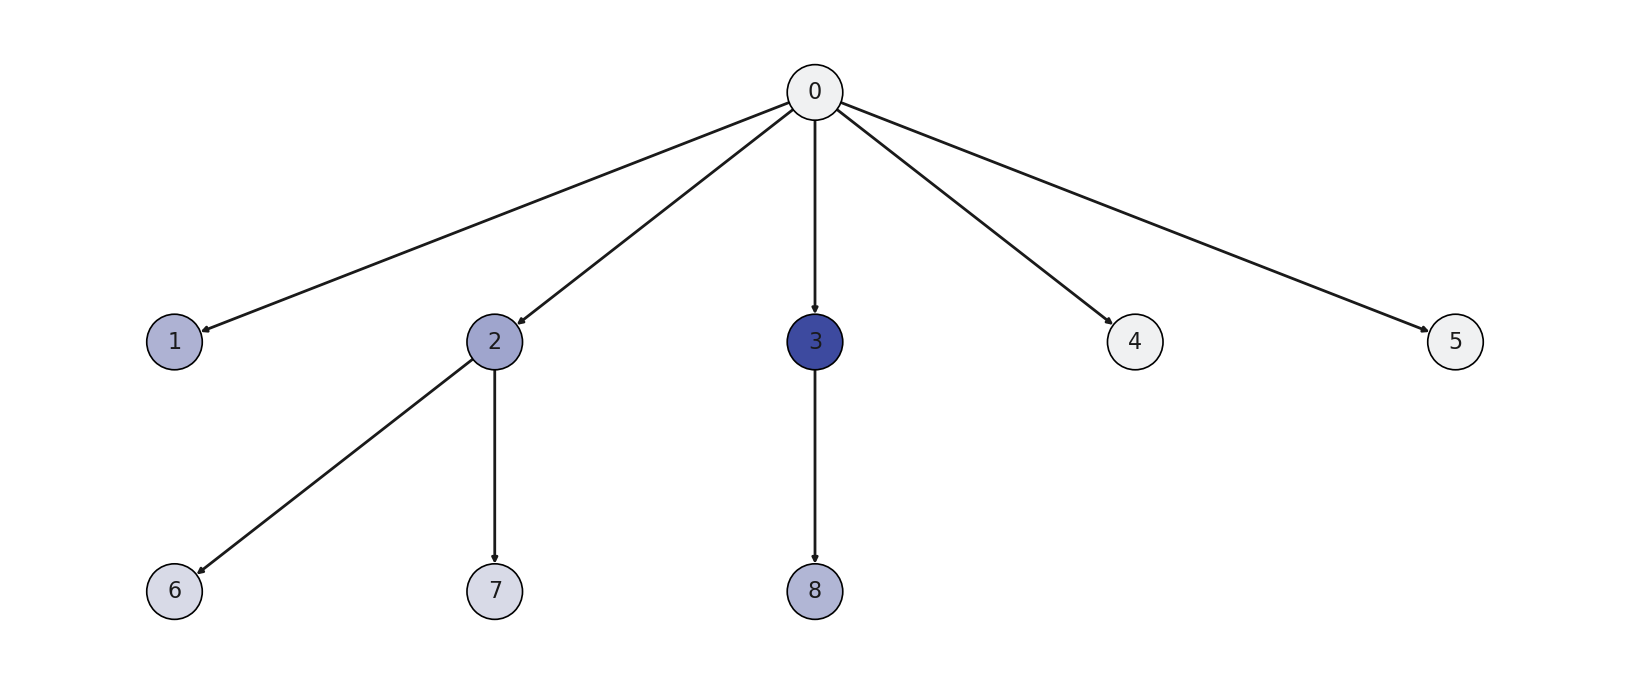

In [5]:
frags = magma_tree['frags']
frag_to_id, id_to_frag = fe.create_new_ids(frags)
edges = [(frag_to_id[j], frag_to_id[key]) for key, val in frags.items() for j in val['parents']]


graph = nx.DiGraph()
graph.add_edges_from(edges)
cmap = sns.light_palette(method_colors['ICEBERG'], reverse=False, as_cmap=True) 

node_intens = [max(frags[id_to_frag[i]]['intens']) for i in graph.nodes]
color_key = [cmap(i) for i in node_intens]

num_nodes, num_edges = graph.number_of_nodes(), graph.number_of_edges()
print(f"Num nodes: {num_nodes}\nNum edges: {num_edges}")

pos = graphviz_layout(graph, prog="dot")
fig = plt.figure(figsize=(5,2), dpi=400)
nx.draw_networkx(graph, pos=pos, node_size=100, #with_labels=False,
                 width=0.5, arrowsize=2, font_size=4, node_color=color_key,
                 ax = fig.gca(), edgecolors = "black",  linewidths=0.3
                 )#edge_color="b")
fig.gca().axis("off")
fig.savefig(spec_res_folder / f"frag_tree_true.pdf", dpi=400, bbox_inches="tight", transparent=True)

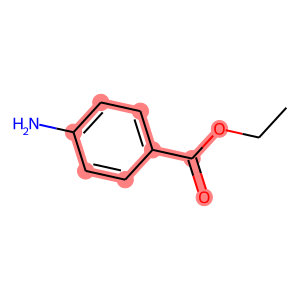

In [6]:

mol_frags_folder = spec_res_folder / "mol_frags"
mol_frags_folder.mkdir(exist_ok=True)
for id_num, frag_hash in id_to_frag.items():
    frag = magma_tree['frags'][frag_hash]['frag']
    draw_dict = engine.get_draw_dict(frag)
    keep_atoms = draw_dict['hatoms']
    keep_bonds = draw_dict['hbonds']
    mol = draw_dict['mol']

    export_mol_highlight(mol = engine.mol, 
                        hatoms=keep_atoms, hbonds=keep_bonds,
                        name=mol_frags_folder / f"mol_{id_num}.pdf",
                        height=500, width=500
                        )

Chem.Kekulize(mol)
Draw.MolToImage(mol, 
                highlightAtoms=keep_atoms,
                highlightBonds=keep_bonds)

In [7]:
## Draw spec --> first let's draw the raw spec?
ex_spec = spec_name
spec_file = data_folder / f"subformulae/no_subform/{ex_spec}.json"
true_spec = json.load(open(spec_file, "r"))

json_spec = magma_folder / f"{ex_spec}.json"
pred_spec =  json.load(open(json_spec, "r"))

frags = pred_spec['frags']
root_inchi = pred_spec['root_inchi']
root_smiles = common.smiles_from_inchi(root_inchi)

# Get ids 
frag_to_id, id_to_frag = fe.create_new_ids(frags)
edges = [(frag_to_id[j], frag_to_id[key]) for key, val in frags.items() for j in val['parents']]

# Get the new IDs and convert to inten list
new_list = engine.frags_to_intens(frags)
new_list = [dict(id=frag_to_id[i['frag_hash']], **i) for i in new_list]

/tmp/ipykernel_317178/2712044328.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])


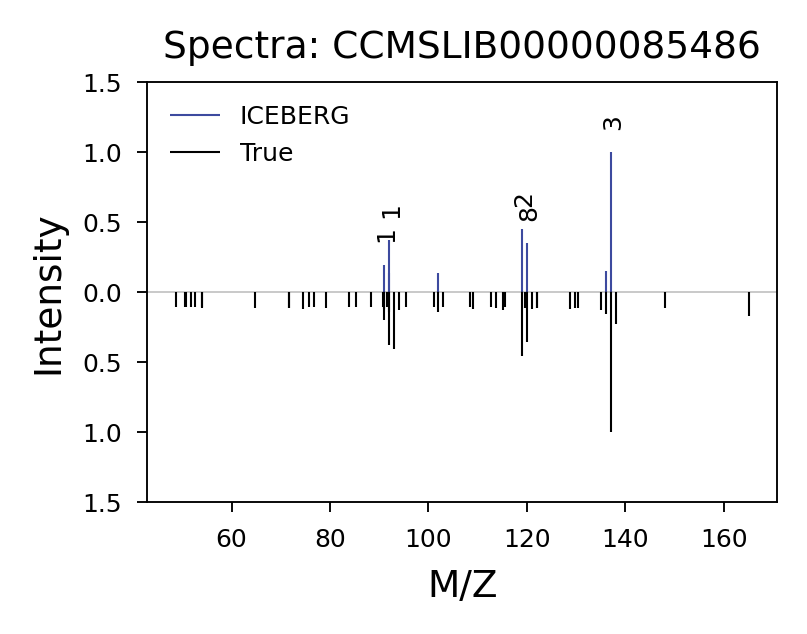

In [8]:
figsize=(2.1, 1.4)
top_k = 5
add_numbers = True
fig = plt.figure(figsize=(figsize), dpi=300)
ax = fig.gca()


# Get top 10
top_entries = sorted(new_list, key=lambda x: x['inten'])[::-1]

for ind, entry in enumerate(top_entries): 
    label_kwargs = {"label":"ICEBERG"} if ind == 0 else {}
    ax.vlines(x=entry['mz'], ymin=0,ymax=entry['inten'], color=method_colors.get("ICEBERG"), linewidth=0.5, **label_kwargs) 

    if ind < top_k and add_numbers:
        temp_hash = entry['frag_hash']
        cur_id = frag_to_id[temp_hash]
        ax.text(x=entry['mz'] - 2, y=entry['inten'] + 0.2, s = f"{cur_id}", fontsize=6, rotation=90) 
        

mz, inten = true_spec['output_tbl']['formula_mass_no_adduct'], true_spec['output_tbl']['rel_inten']
for ind, (m, i) in enumerate(zip(mz, inten)):
    label_kwargs = {"label":"True"} if ind == 0 else {}
    ax.vlines(x=m, ymin=0,ymax=-i, color="black", linewidth=0.5, **label_kwargs,
    )

ax.axhline(y=0, xmin=0, xmax=1, color="black", linewidth=0.1)
ax.set_xlabel("M/Z")
ax.set_ylabel("Intensity")
ax.set_title(f"Spectra: {ex_spec}")
ax.set_ylim([-1.5, 1.5])
ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
ax.legend(**legend_params, loc="upper left")
set_size(*figsize, ax)

fig.savefig(spec_res_folder / f"spec_true.pdf", dpi=300, bbox_inches="tight", transparent=True)
with open(spec_res_folder / f"info_{ex_spec}.txt", "w") as fp:
    fp.write(smi)
mol_obj = Chem.MolFromSmiles(root_smiles)
plot_utils.export_mol(mol_obj, spec_res_folder/ f"{ex_spec}_mol.pdf", width=100, height=100)

## Drawing graphs

Drawing fragment tree diagrams for figure 1

Num nodes: 9
Num edges: 8


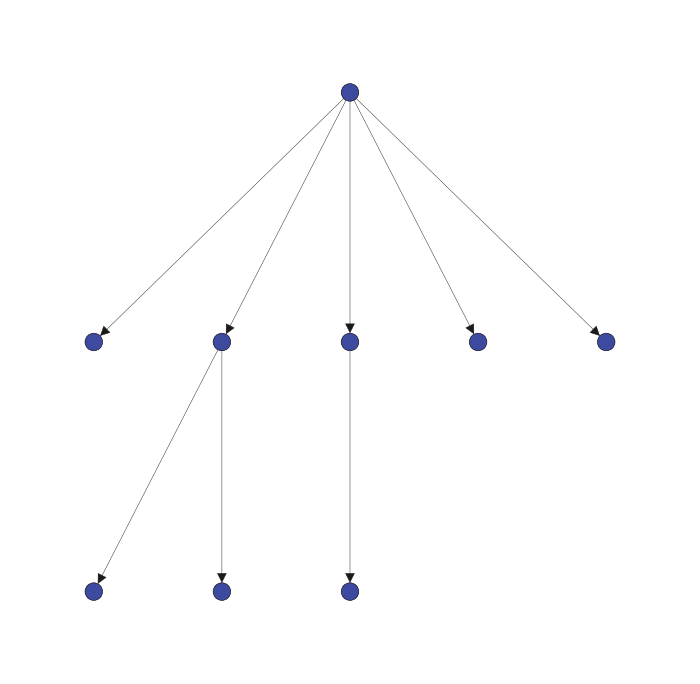

In [22]:
frags = magma_tree['frags']
frag_to_id, id_to_frag = fe.create_new_ids(frags)
edges = [(frag_to_id[j], frag_to_id[key]) for key, val in frags.items() for j in val['parents']]


graph = nx.DiGraph()
graph.add_edges_from(edges)
cmap = sns.light_palette(method_colors['ICEBERG'], reverse=False, as_cmap=True,)

node_intens = [max(frags[id_to_frag[i]]['intens']) for i in graph.nodes]
color_key = [cmap(i + 1e-7) for i in node_intens]
color_key = [cmap(1 + 1e-7) for i in node_intens]

num_nodes, num_edges = graph.number_of_nodes(), graph.number_of_edges()
print(f"Num nodes: {num_nodes}\nNum edges: {num_edges}")

pos = graphviz_layout(graph, prog="dot")
fig = plt.figure(figsize=(2,2), dpi=400)
# nx.draw_networkx(graph, pos=pos, node_size=5, with_labels=False,
#                  width=0.5, arrowsize=2, font_size=4, node_color=color_key,
#                  ax = fig.gca(), edgecolors = "black",  linewidths=0.3
#                  )#edge_color="b")
nx.draw_networkx(graph, pos=pos, node_size=10, with_labels=False,
                 width=0.08, arrowsize=4, font_size=4, node_color=color_key,
                 ax = fig.gca(), edgecolors = "black",  linewidths=0.1
                 )#edge_color="b")



fig.gca().axis("off")
# set_size(2, 2, fig.gca())
fig.savefig(spec_res_folder / f"frag_tree_sparse_sche.pdf", dpi=400, bbox_inches="tight", transparent=True)

In [12]:
new_engine = fe.FragmentEngine(mol_str=root_inchi, mol_str_type="inchi")
new_engine.generate_fragments()

frag_dict = new_engine.frag_to_entry

Num nodes: 150
Num edges: 334


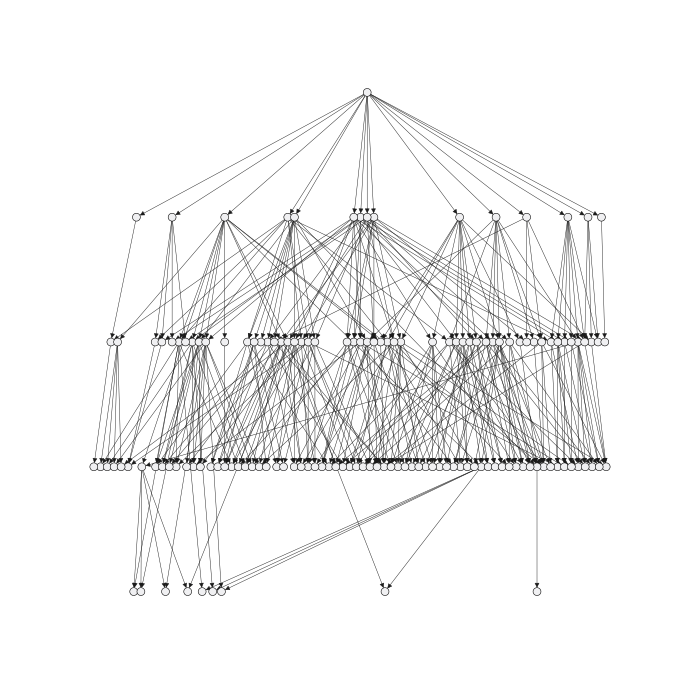

In [26]:
frags = frag_dict
frag_to_id, id_to_frag = fe.create_new_ids(frags)
edges = [(frag_to_id[j], frag_to_id[key]) for key, val in frags.items() for j in val['parent_hashes']]


graph = nx.DiGraph()
graph.add_edges_from(edges)
cmap = sns.light_palette(method_colors['ICEBERG'], reverse=False, as_cmap=True) 

# node_intens = [max(frags[id_to_frag[i]]['intens']) for i in graph.nodes]
node_intens = [1 for i in graph.nodes]
color_key = [cmap(i) for i in node_intens]

num_nodes, num_edges = graph.number_of_nodes(), graph.number_of_edges()
print(f"Num nodes: {num_nodes}\nNum edges: {num_edges}")

pos = graphviz_layout(graph, prog="dot")
fig = plt.figure(figsize=(2,2), dpi=400)
nx.draw_networkx(graph, pos=pos, 
                 node_size=2, 
                 with_labels=False,
                 width=0.08, arrowsize=1.8, font_size=4, node_color=color_key,
                 ax = fig.gca(), edgecolors = "black",  linewidths=0.1
                 )#edge_color="b")
fig.gca().axis("off")
# set_size(2, 2, fig.gca())
fig.savefig(spec_res_folder / f"frag_tree_dense_scheme.pdf", dpi=400, bbox_inches="tight", transparent=True)